In [1]:
import yfinance as yf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as scs
import statsmodels.api as sm 
import pmdarima as pm 
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.style.use('bmh')

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def adf_test(x):
    res = adfuller(x, autolag='AIC')
    print('='*40)
    print("***** ADF test *****")
    print("H0: time series is NOT stationary")
    print('-'*40)
    cols = ['Test Statistics', 'p-value', '# of Lags Used', '# of Observations Used']
    for col, val in zip(cols, res[0:4]):
        print(f"{col:25s} {val:.4f}")
    p_val = res[1]
    for k, v in res[4].items():
        alpha = float(k.strip('%'))/100
        name = f"Critical Value ({k})"
        print(f"{name:25s} {v:.4f}", end=' ')
        if p_val < alpha: 
            print("--> Reject H0")
        else:
            print("--> NOT Reject H0")
    print('='*40)
    return res 

def kpss_test(x, h0_type='c'):
    res = kpss(x, regression=h0_type, nlags='auto')
    print('='*40)
    print("***** KPSS test *****")
    print("H0: time series is stationary")
    print('-'*40)
    cols = ['Test Statistics', 'p-value', '# of Lags Used', '# of Observations Used']
    for col, val in zip(cols, res[0:3]):
        print(f"{col:25s} {val:.4f}")
    p_val = res[1]
    for k, v in res[3].items():
        alpha = float(k.strip('%'))/100
        name = f"Critical Value ({k})"
        print(f"{name:25s} {v:.4f}", end=' ')
        if p_val < alpha: 
            print("--> Reject H0")
        else:
            print("--> NOT Reject H0")
    print('='*40)
    return res 

def plot_autocorrelation(x, nlags=40, alpha=0.05):
    fig, ax = plt.subplots(2,1, figsize=(12,8))
    plot_acf(x, lags=nlags, alpha=alpha, ax=ax[0])
    plot_pacf(x, lags=nlags, alpha=alpha, ax=ax[1])
    plt.tight_layout()
    plt.show()
    
def plot_residuals(resids):
    resids_norm = (resids - np.nanmean(resids)) / np.nanstd(resids)
    resids_norm = resids_norm[~np.isnan(resids_norm)]
    fig, ax = plt.subplots(2,2, figsize=(12,8))

    ax[0,0].plot(resids_norm)
    ax[0,0].set_title('Standardized Residuals')

    sns.histplot(resids_norm, ax=ax[0,1], kde=True, stat='density')
    r_range = np.linspace(-1.96*2, 1.96*2, 1000)
    norm_pdf = scs.norm.pdf(r_range)
    ax[0,1].plot(r_range, norm_pdf, linestyle='--', color='k', label='N(0,1)')
    ax[0,1].set_title('Distribution of Standardized Residuals')
    ax[0,1].legend()

    sm.qqplot(resids_norm, line='s', ax=ax[1,0])
    ax[1,0].set_title('Q-Q plot')

    plot_acf(resids_norm, ax=ax[1,1], lags=40)
    ax[1,1].set_title('ACF')

    plt.tight_layout()
    plt.show()
    
def ljung_box_test(resids):
    # Ljung-Box test
    # H0: No significant autocorrelation

    ljung_box_res = acorr_ljungbox(resids, return_df=True)

    fig, ax = plt.subplots(figsize=(12,5))

    p_val = ljung_box_res['lb_pvalue']
    ax.scatter(range(len(p_val)), p_val)
    ax.axhline(y=0.05, xmin=0, xmax=len(p_val), color='red', linestyle='--')

    ax.set_title('Ljung-Box test')
    ax.set_ylabel('p-value')
    ax.set_xlabel('Lag')

    plt.tight_layout()
    plt.show()

In [4]:
data = yf.download('SPY', period='5y', interval='1d', adjusted=True,progress=False)
data = data.resample('W').last()
print(data.shape)
data.head()

(261, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-02-26,235.460007,236.789993,235.410004,236.740005,216.672729,82381600
2017-03-05,238.169998,238.610001,237.729996,238.419998,218.210358,81974300
2017-03-12,237.970001,238.020004,236.589996,237.690002,217.542221,81991700
2017-03-19,237.750000,237.970001,237.029999,237.029999,217.881912,89002100
2017-03-26,234.380005,235.039993,232.960007,233.860001,214.968033,112504900


In [5]:
data['price_diff'] = data.Close.diff(1)
print(data.shape)
data.head()

(261, 7)


,Open,High,Low,Close,Adj Close,Volume,price_diff
Date,,,,,,,
2017-02-26,235.460007,236.789993,235.410004,236.740005,216.672729,82381600,NaN
2017-03-05,238.169998,238.610001,237.729996,238.419998,218.210358,81974300,1.679993
2017-03-12,237.970001,238.020004,236.589996,237.690002,217.542221,81991700,-0.729996
2017-03-19,237.750000,237.970001,237.029999,237.029999,217.881912,89002100,-0.660004
2017-03-26,234.380005,235.039993,232.960007,233.860001,214.968033,112504900,-3.169998


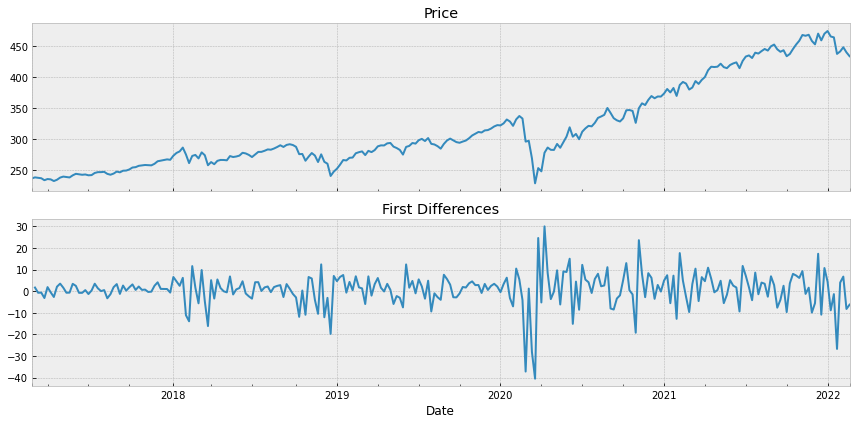

In [6]:
fig, ax = plt.subplots(2, 1 , sharex=True, figsize=(12,6))

data.Close.plot(ax=ax[0])
ax[0].set_title('Price')

data.price_diff.plot(ax=ax[1])
ax[1].set_title('First Differences')

plt.tight_layout()
plt.show()

***** ADF test *****
H0: time series is NOT stationary
----------------------------------------
Test Statistics           -17.3347
p-value                   0.0000
# of Lags Used            0.0000
# of Observations Used    259.0000
Critical Value (1%)       -3.4559 --> Reject H0
Critical Value (5%)       -2.8728 --> Reject H0
Critical Value (10%)      -2.5728 --> Reject H0
***** KPSS test *****
H0: time series is stationary
----------------------------------------
Test Statistics           0.0807
p-value                   0.1000
# of Lags Used            1.0000
Critical Value (10%)      0.3470 --> NOT Reject H0
Critical Value (5%)       0.4630 --> NOT Reject H0
Critical Value (2.5%)     0.5740 --> NOT Reject H0
Critical Value (1%)       0.7390 --> NOT Reject H0


/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


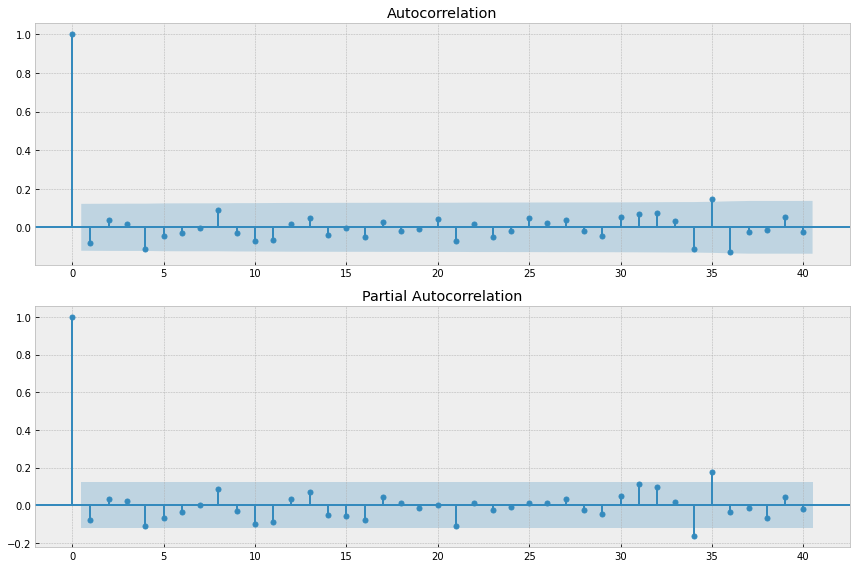

In [7]:
adf_test(data.price_diff.dropna())
kpss_test(data.price_diff.dropna())
plot_autocorrelation(data.price_diff.dropna())

In [8]:
arima_model = ARIMA(data.Close, (2,1,1)).fit(disp=0)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  260
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -900.763
Method:                       css-mle   S.D. of innovations              7.733
Date:                Tue, 22 Feb 2022   AIC                           1811.526
Time:                        19:46:55   BIC                           1829.330
Sample:                    03-05-2017   HQIC                          1818.684
                         - 02-20-2022                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7592      0.460      1.650      0.099      -0.143       1.661
ar.L1.D.Close     0.0024      0.656      0.004      0.997      -1.282       1.287
ar.L2.D.Close     0.0379      0.080      0.476      0.634      -0.118       0.194
ma.L1.D.Close    -0.0791      0.653     -0.121      0.904      -1.360       1.202
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            5.1034           +0.0000j            5.1034            0.0000
AR.2           -5.1661           +0.0000j            5.1661            0.5000
MA.1           12.6478           +0.0000j           12.6478            0.0000
-----------------------------------------------------------------------------
"""

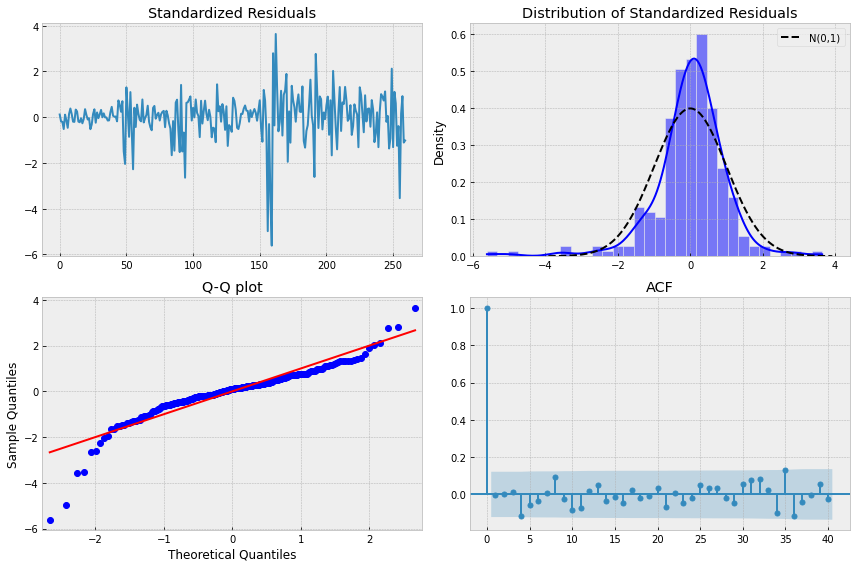

In [9]:
plot_residuals(arima_model.resid.values)

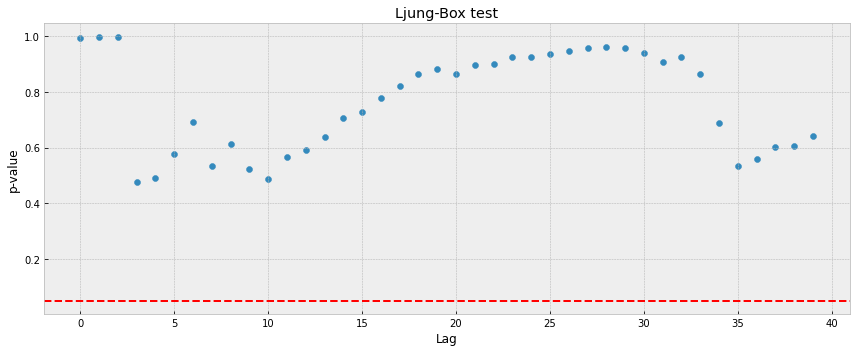

In [10]:
ljung_box_test(arima_model.resid.values)

## Auto-ARIMA

In [11]:
train, test = train_test_split(data.Close, test_size=0.2)

In [12]:
model = pm.auto_arima(train, error_action='ignore', suppress_warnings=True, 
                     seasonal=False, stepwise=False, approximation=False, n_jobs=-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  208
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -719.039
Date:                Tue, 22 Feb 2022   AIC                           1442.077
Time:                        19:47:01   BIC                           1448.743
Sample:                             0   HQIC                          1444.773
                                - 208                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7531      0.590      1.276      0.202      -0.404       1.910
sigma2        60.9075      2.995     20.336      0.000      55.037      66.778
===================================================================================
Ljung-Box (Q):                       44.86   Jarque-Bera (JB):               530.77
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               7.18   Skew:                            -1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

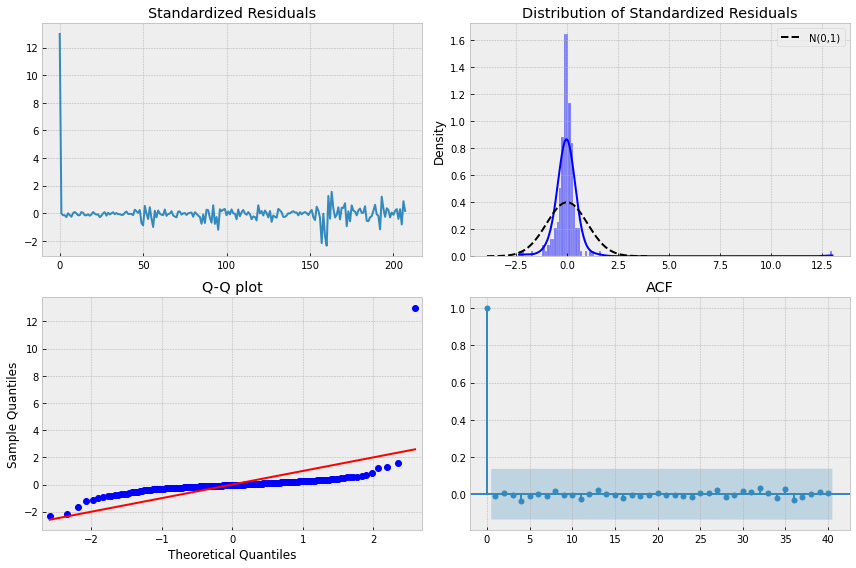

In [13]:
 plot_residuals(model.resid())

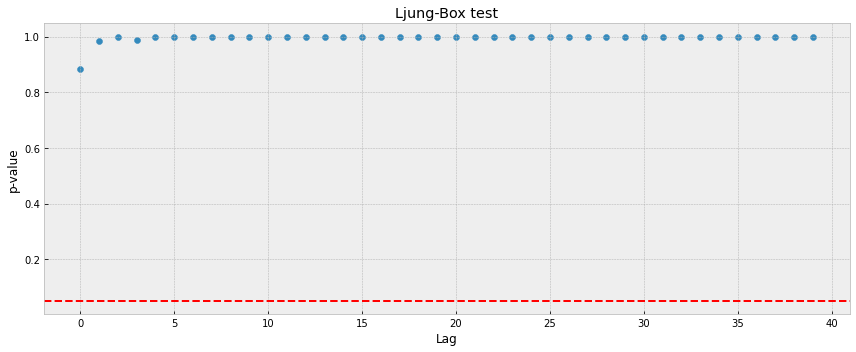

In [14]:
ljung_box_test(model.resid())

In [15]:
forecasts = model.predict(len(test), return_conf_int=True)

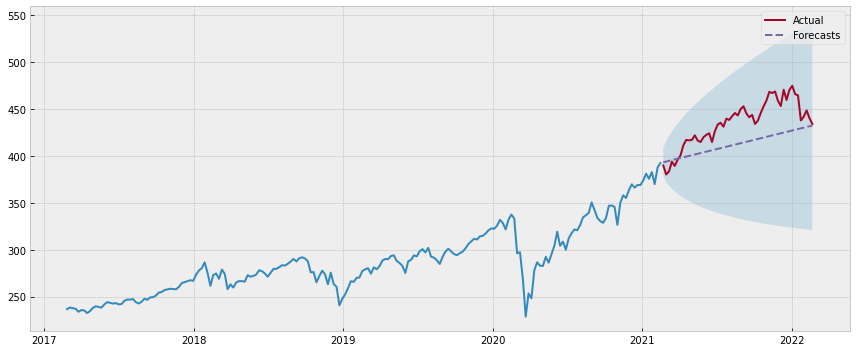

In [16]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(train)
ax.plot(test, label='Actual')
ax.plot(test.index, forecasts[0], linestyle='--', label='Forecasts')
ax.fill_between(test.index, forecasts[1][:,0], forecasts[1][:,1], alpha=0.2)
ax.legend()

plt.tight_layout()
plt.show()

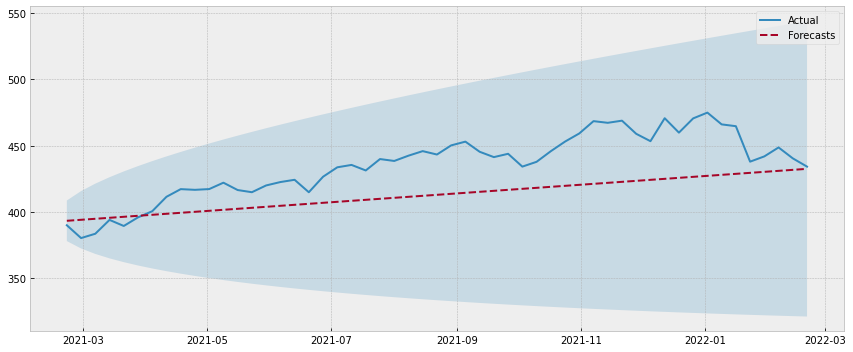

In [17]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(test, label='Actual')
ax.plot(test.index, forecasts[0], linestyle='--', label='Forecasts')
ax.fill_between(test.index, forecasts[1][:,0], forecasts[1][:,1], alpha=0.2)
ax.legend()

plt.tight_layout()
plt.show()